#  Final: Classifying news stories as true or fake

#### Randy Thompson, Ben Horvath

With the rise of social media, everyone has an equal opportunity to create, share and distribute articles of their choosing. Some of these articles are written without sources or evidence for the claims they make. These "fake news" articles may have patterns of text that can make them identifiable as real or fake.

Our goal is to classify whether a piece is fake or not _based on its substantive text content only_. The dataset is carefully prepared to remove any 'hints' to the model that detract from this goal (e.g., removing datelines).

The data can be downloaded from Kaggle at https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset. It is not present in the Github repo because of its size.

We make heavy use of tidyverse R functionality. Especially useful here is the `tidytext` package, which drastically simplifies the calculation of TF-IDF matrices; and the `caret` library for cross-validated modeling. Load necessary libraries:

In [3]:
library(caret)
library(dplyr)
library(ggplot2)
library(lubridate)  # easy dates
library(stringr)    # easy regex
library(textstem)   # stemming, lemmatization
library(tidytext)   # easy TF-IDF
library(tidyverse)
library(janitor)
library(topicmodels)
library(tm)

## Load the data

The data comes seperated in two CSVs of about equal size, one for true news stories, and other for fake. We load them, assign our dependent variable $y = \{fake, true\}$, and combine them.

In [4]:
fake <- read_csv('~/CUNY/DATA 620/final/Fake.csv') %>%
  mutate(y='fake')

real <- read_csv('~/CUNY/DATA 620/final/True.csv') %>%
  mutate(y='real')

# rename date to dt to keep R happy
df <- rbind(fake, real) %>%
  rename(dt = 'date') %>%
  mutate(dt = parse_date_time(dt, '%B %d, $Y'))

head(df, 1)

Parsed with column specification:
cols(
  title = col_character(),
  text = col_character(),
  subject = col_character(),
  date = col_character()
)

Parsed with column specification:
cols(
  title = col_character(),
  text = col_character(),
  subject = col_character(),
  date = col_character()
)

Warning message:
" 45 failed to parse."


title,text,subject,dt,y
<chr>,<chr>,<chr>,<dttm>,<chr>
Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year, President Angry Pants tweeted. 2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America! Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t even allow him to rise above the gutter long enough to wish the American citizens a happy new year! Bishop Talbert Swan (@TalbertSwan) December 31, 2017no one likes you Calvin (@calvinstowell) December 31, 2017Your impeachment would make 2018 a great year for America, but I ll also accept regaining control of Congress. Miranda Yaver (@mirandayaver) December 31, 2017Do you hear yourself talk? When you have to include that many people that hate you you have to wonder? Why do the they all hate me? Alan Sandoval (@AlanSandoval13) December 31, 2017Who uses the word Haters in a New Years wish?? Marlene (@marlene399) December 31, 2017You can t just say happy new year? Koren pollitt (@Korencarpenter) December 31, 2017Here s Trump s New Year s Eve tweet from 2016.Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don t know what to do. Love! Donald J. Trump (@realDonaldTrump) December 31, 2016This is nothing new for Trump. He s been doing this for years.Trump has directed messages to his enemies and haters for New Year s, Easter, Thanksgiving, and the anniversary of 9/11. pic.twitter.com/4FPAe2KypA Daniel Dale (@ddale8) December 31, 2017Trump s holiday tweets are clearly not presidential.How long did he work at Hallmark before becoming President? Steven Goodine (@SGoodine) December 31, 2017He s always been like this . . . the only difference is that in the last few years, his filter has been breaking down. Roy Schulze (@thbthttt) December 31, 2017Who, apart from a teenager uses the term haters? Wendy (@WendyWhistles) December 31, 2017he s a fucking 5 year old Who Knows (@rainyday80) December 31, 2017So, to all the people who voted for this a hole thinking he would change once he got into power, you were wrong! 70-year-old men don t change and now he s a year older.Photo by Andrew Burton/Getty Images.",News,2017-12-31,fake


The dataset gives  us the title of the text, the text  itself, a classification of the news story, and the date of publishing.

## Exploratory analysis

Before modeling, we get to know our dataset more thoroughly. First, inspect the distribution of the dependent variable, which shows a balanced dataset.

In [5]:
table(df$y)


 fake  real 
23481 21417 

In [6]:
table(df$subject)


Government News       left-news     Middle-east            News        politics 
           1570            4459             778            9050            6841 
   politicsNews         US_News       worldnews 
          11272             783           10145 

The table below shows the distribution of subject these categories between fake and real news. We see that the fake news is labeled as either `politicsNews` or as `worldnews`, while the real news is labeled as everything else but those two. This suggests _subject should not be used as a model feature_.

In [7]:
prop.table(table(df$y, df$subject), 1)

      
       Government News  left-news Middle-east       News   politics
  fake      0.06686257 0.18989822  0.03313317 0.38541800 0.29134194
  real      0.00000000 0.00000000  0.00000000 0.00000000 0.00000000
      
       politicsNews    US_News  worldnews
  fake   0.00000000 0.03334611 0.00000000
  real   0.52631087 0.00000000 0.47368913

The `text` column will be ommitted in the NLP analysis because it is simply too much data for be easily computer on the present machines. However, we can still try to create simple features using regular expressions from the text. We examine a few of these below:

In [8]:
# Presence of Twitter handle
df$twitter_handle <- str_detect(df$text, '(?<!\\w)@[\\w+]{1,15}\\b')
prop.table(table(df$y, df$twitter_handle), 1)

      
            FALSE       TRUE
  fake 0.73419106 0.26580894
  real 0.98706575 0.01293425

The above shows that their is an association between the presence of a twitter handle and the reality of a news story.

Below shows a slighly weaker association with profanity (using a very crude and very incomplete regex):

In [9]:
PROFANITY <- 'fuck|shit|bastard|bitch|whore|goddamn'

df$profanity <- str_detect( tolower(df$text), PROFANITY)
prop.table(table(df$y, df$profanity), 1)

      
             FALSE        TRUE
  fake 0.942978425 0.057021575
  real 0.996964886 0.003035114

Finally, we can count the number of all-caps words in the text. Interestingly, there's no real difference in the distributions. Below we will see that this is due to the presence of acronyms in real news stories, as well as dateline in all-caps, e.g., WASHINGTON (Reuters). A better solution would be to count the length (in words) of all-caps phrases which do not appear often in real news stories.

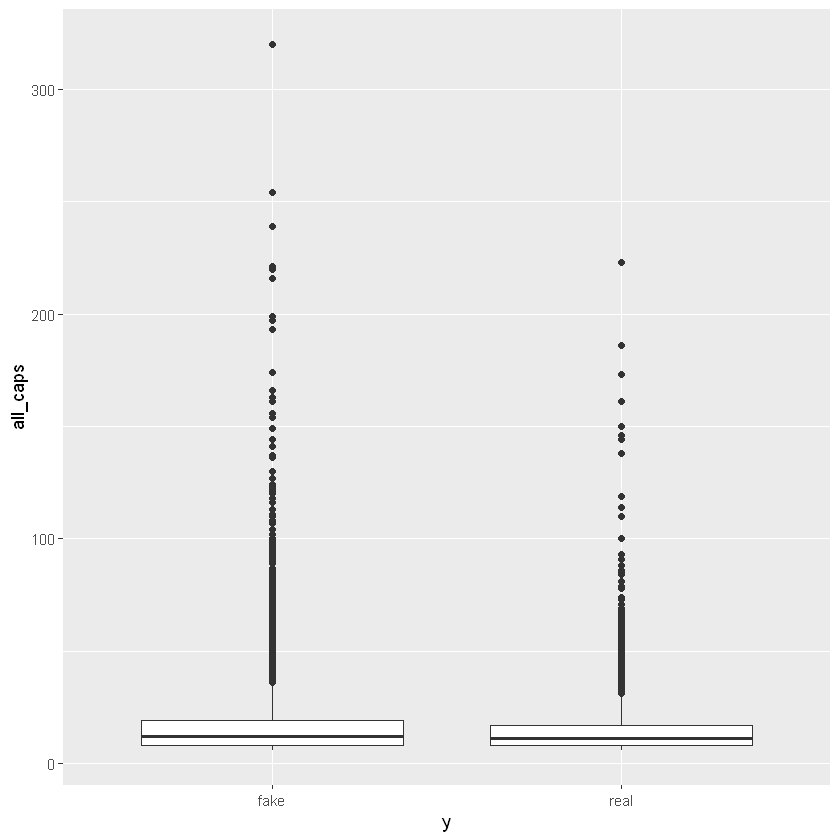

In [10]:
ALL_CAPS <- '(\\b[A-Z][A-Z]+|\\b[A-Z]\\b)'
df$all_caps <- str_count(df$text, ALL_CAPS)

ggplot(df %>% filter(all_caps > 5), aes(x=y, y=all_caps)) + geom_boxplot()

Finally, examine the distribution of fake and real news stories over time. There are no fake stories recorded until just after 2016, and following the spring of 2017 the real stories shoot up in quantity relative to the fake stories.

This could suggest the optimal sample should be  restricted to Jan. 2016 through June 2017, which would be about 26 thousand samples. 

Warning message:
"Removed 1 rows containing missing values (geom_path)."


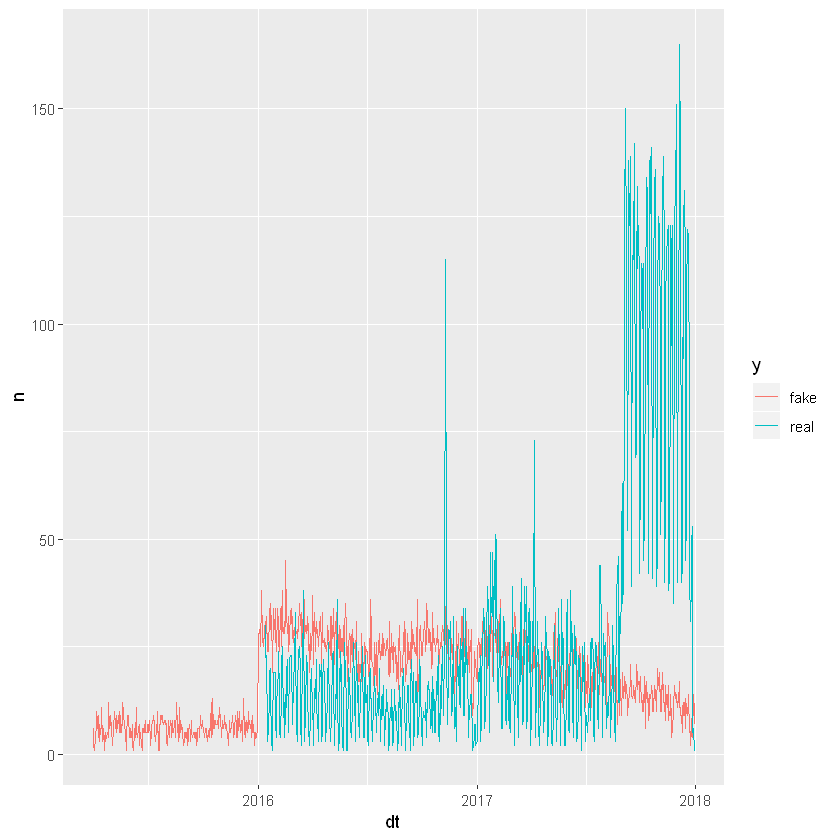

In [11]:
df %>%
  group_by(dt, y) %>%
  summarise(n=n_distinct(title)) %>%
  ggplot(aes(x=dt, y=n, colour=y)) + geom_line()

We will perform the same operations as above on the title:

In [12]:
df$title_twitter_handle <- str_detect(df$title, '(?<!\\w)@[\\w+]{1,15}\\b')
df$title_all_caps <- str_count(df$title, ALL_CAPS)
df$title_profanity <- str_detect( tolower(df$title), PROFANITY)

## Data cleaning

Using the story titles as IDs, there are duplicated stories. These are removed by keeping only the latest version:

In [13]:
length(df$title); length(unique(df$title))

[1] 44898

[1] 38728

In [14]:
df <- df %>%
  select(y, title, dt) %>% 
  arrange(title, desc(dt)) %>%
  group_by(title) %>%
  slice(which.max(dt)) %>% 
  filter(dt > date("2016-01-01") && dt < date("2017-07-01"))  %>% 
  ungroup()

length(df$title); length(unique(df$title))

[1] 21770

[1] 21770

All of the real news stories are from Reuters, and all Reuters news stories begin with a dateline, e.g., WASHINGTON (Rueters). These are removed by a very simple Regex that matches the beginning of the story up to the first hyphen. It appears to be effective enough. Additionally, we remove any other mentions of 'Reuters' just to be sure, and numbers:

In [15]:
df <- df %>%
  mutate(title = str_remove(title, '^[^\\-]*\\-\\s+'),
         title = str_remove(tolower(title), 'reuters'),
         title = str_remove(title, '[0-9]+'),
         title = str_remove(title, '[:punct:]+'),
         title = str_trim(title, side = "both"), 
         title = str_squish(title))

Often, at this point in NLP process, we normally remove punctuation and a list of stop words. However, it may be that there are differences in punctuations and stop words between fake and real news. We thus retain them.

### Test/Training Split

Now we're going to separate our test and training data. By keeping some data out of our model will ensure that we have data the model hasn't seen to get a sense of how our model will work on new data. 

In [16]:
indexed <- createDataPartition(df$y, p=0.7, list=FALSE, times=1)
df_train <- df[indexed,]
df_test <- df[-indexed,]

Warning message:
"The `i` argument of ``[`()` can't be a matrix as of tibble 3.0.0.
Convert to a vector.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."


### Tokenize

However, we will be conducting other stemming, requiring tokenization. Recall that  we are concerned only with the title for now:

In [17]:
tokens <- df_train %>%
  select(y, title) %>%
  unique() %>% 
  unnest_tokens(word, title, drop=FALSE) 


tokens2 <- df_train %>%
  select(y, title) %>%
  unique() %>% 
  mutate(title2 = title) %>% 
  unnest_tokens(output = word, input = title2, token = "ngrams", n = 2) 

tokens3 <- df_train %>%
  select(y, title) %>%
  unique() %>% 
  mutate(title2 = title) %>% 
  unnest_tokens(output = word, input = title2, token = "ngrams", n = 3) 

tokens <- rbind(tokens, tokens2, tokens3)

head(tokens)

y,title,word
<chr>,<chr>,<chr>
real,"absolutely false,' trump says defiantly after women's groping allegations",absolutely
real,"absolutely false,' trump says defiantly after women's groping allegations",false
real,"absolutely false,' trump says defiantly after women's groping allegations",trump
real,"absolutely false,' trump says defiantly after women's groping allegations",says
real,"absolutely false,' trump says defiantly after women's groping allegations",defiantly
real,"absolutely false,' trump says defiantly after women's groping allegations",after


### Stemming

We will, of course, conduct stemming on the title, using the `textstem` library, which uses a stemmer based on the `libstemmer` C library developed in the early 2000s.

In [18]:
stems <- tokens %>%
  mutate(stemmed = stem_words(word))

head(stems)

y,title,word,stemmed
<chr>,<chr>,<chr>,<chr>
real,"absolutely false,' trump says defiantly after women's groping allegations",absolutely,absolut
real,"absolutely false,' trump says defiantly after women's groping allegations",false,fals
real,"absolutely false,' trump says defiantly after women's groping allegations",trump,trump
real,"absolutely false,' trump says defiantly after women's groping allegations",says,sai
real,"absolutely false,' trump says defiantly after women's groping allegations",defiantly,defiantli
real,"absolutely false,' trump says defiantly after women's groping allegations",after,after


###  Lemmatize

Next, we clean up the tokens further by lemmatization, again using the `textstem` library:

In [19]:
lemmas <- stems %>%
  mutate(lemma = lemmatize_words(stemmed))

head(lemmas)

y,title,word,stemmed,lemma
<chr>,<chr>,<chr>,<chr>,<chr>
real,"absolutely false,' trump says defiantly after women's groping allegations",absolutely,absolut,absolut
real,"absolutely false,' trump says defiantly after women's groping allegations",false,fals,fals
real,"absolutely false,' trump says defiantly after women's groping allegations",trump,trump,trump
real,"absolutely false,' trump says defiantly after women's groping allegations",says,sai,sai
real,"absolutely false,' trump says defiantly after women's groping allegations",defiantly,defiantli,defiantli
real,"absolutely false,' trump says defiantly after women's groping allegations",after,after,after


## Feature engineering

**ADD ADDITIONAL FEATURES HERE, INCORPORATE FROM ABOVE?**

Now we  calculate TF-IDF. Those scores and all other features are incorporated to a data frame called `X` for later machine learning.

In [20]:
token_count <- lemmas %>%
  count(title, y, lemma, sort=TRUE) %>%
  ungroup()
head(token_count)

title,y,lemma,n
<chr>,<chr>,<chr>,<int>
"mother of son killed in afghanistan to antiamerican er’s qb colin kaepernick: “my heart is exploding, my lungs are without air, my blood is boiling, my body is shaking, and tears are running down my face” [video]",fake,my,5
whoa black woman fed up with black racists nails it: “many black people voted for barack obama simply because he was black…and now your black god has failed you!” [video],fake,black,5
"andrew breitbart “i don’t care who our candidate is…i will march behind whoever our candidate is, because if we don’t…we lose!”[video]",fake,i,4
"boom mother of black son murdered by blacks: “i don’t preach black lives matter, because black lives only matters when law enforcement is involved” [video]",fake,black,4
"democrats chant warning to gop as trumpcare passes na na na na, hey hey hey, goodbye! (video)",fake,na,4
hillary panders to black radio hosts in attempt to tie herself to racist beyonce songhost asks if she needs mouth to mouth or cpr? [watch],fake,to,4


In [21]:
total_words <- token_count %>%
  group_by(title, y) %>%
  summarise(total = sum(n), .groups='keep')
head(total_words)

title,y,total,.groups
<chr>,<chr>,<int>,<chr>
$5 million down the drain….day 5 wi recount: trump +25,fake,30,keep
000 ma drug cases could be thrown out because of drug stealing lab scandal,fake,39,keep
57 degrees: kevin bacon’s cultural mantle shattered by zuckerberg,fake,24,keep
700 syrian refugees approved resettlement to u.s.: homeland security chief,real,27,keep
a barb at germany puts trump administration on collision course with eu,real,33,keep
a bipartisan miracle: federal employee health plans add critical autism benefit,fake,30,keep


In [22]:
token_count <- token_count %>%
  bind_tf_idf(lemma, title, n)

# Remove tokens with less than 10 instances
tc <- token_count %>%
  group_by(lemma) %>%
  summarise(n=sum(n), .groups='keep') %>%
  filter(n > 10)

token_count <- token_count %>%
  filter(lemma %in% tc$lemma)

head(token_count)

title,y,lemma,n,tf,idf,tf_idf
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
"mother of son killed in afghanistan to antiamerican er’s qb colin kaepernick: “my heart is exploding, my lungs are without air, my blood is boiling, my body is shaking, and tears are running down my face” [video]",fake,my,5,0.04629630,5.382133,0.24917283
whoa black woman fed up with black racists nails it: “many black people voted for barack obama simply because he was black…and now your black god has failed you!” [video],fake,black,5,0.05555556,3.784190,0.21023276
"andrew breitbart “i don’t care who our candidate is…i will march behind whoever our candidate is, because if we don’t…we lose!”[video]",fake,i,4,0.05797101,2.414653,0.13997991
"boom mother of black son murdered by blacks: “i don’t preach black lives matter, because black lives only matters when law enforcement is involved” [video]",fake,black,4,0.05555556,3.784190,0.21023276
hillary panders to black radio hosts in attempt to tie herself to racist beyonce songhost asks if she needs mouth to mouth or cpr? [watch],fake,to,4,0.05555556,1.098153,0.06100848
how hillary clinton has secured her husbands legacy as “a rapist” and hers as an “enabler” [video],fake,a,4,0.08333333,1.906182,0.15884848


In [23]:
# Make into a wide, tidy data frame for machine learning
X <- token_count %>%
  select(title, y, lemma, tf_idf) %>% 
  filter(lemma != 'title',
         lemma != 'y') %>%  # remove because I'm already using 'title' and 'y'
  unique() %>%  
  tidyr::spread(lemma, tf_idf) %>%
  janitor::clean_names() %>%  # VERY HANDY FUNCTION!
  replace(is.na(.), 0) %>%
  select(-contains('_2'))

Warning message:
"The `x` argument of `as_tibble.matrix()` must have column names if `.name_repair` is omitted as of tibble 2.0.0.
Using compatibility `.name_repair`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated."


In [24]:
dim(X)
head(X[, c(1,2,601, 709, 804, 945)])
prop.table(table(X$y))

[1] 15223  3611

title,y,confid,death_of,doe,f_cking
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
$5 million down the drain….day 5 wi recount: trump +25,fake,0,0,0,0
000 ma drug cases could be thrown out because of drug stealing lab scandal,fake,0,0,0,0
57 degrees: kevin bacon’s cultural mantle shattered by zuckerberg,fake,0,0,0,0
700 syrian refugees approved resettlement to u.s.: homeland security chief,real,0,0,0,0
a barb at germany puts trump administration on collision course with eu,real,0,0,0,0
a bipartisan miracle: federal employee health plans add critical autism benefit,fake,0,0,0,0



     fake      real 
0.6222821 0.3777179 

Our final TF-IDF matrix has almost 39,000 articles (rows), 4156 token TF-IDF scores (columns), and a reasonably balanced distribution of fake and real news.

**ADD ADDITIONAL FEATURES HERE!**

## Modeling

With almost 14,000 potential variable, we would like to drop those to a more reasonable set. First, remove low variance using the ratio of a variable's unique values to its sample size. By default, `nearZeroVar` suggests all the variables have sparse variancel; this is fixed by modifying the default value for `uniqueCut`:

In [29]:
# Remove low variance variables
low_variance <- nearZeroVar(X, uniqueCut=.1)
print(low_variance)

  [1]    4    7   10   11   12   18   19   20   21   23   25   27   30   33   36
 [16]   37   38   41   42   45   47   48   49   53   54   55   57   58   59   61
 [31]   62   64   66   67   76   77   78   79   80   81   82   84   86   87   89
 [46]   90   91   93   96   99  103  106  108  109  110  112  115  116  117  118
 [61]  119  121  123  126  129  130  133  134  136  140  149  150  155  156  160
 [76]  163  164  166  167  168  171  174  176  184  186  187  189  190  191  192
 [91]  196  202  203  205  208  209  210  211  213  216  217  219  221  222  228
[106]  229  230  233  237  239  240  243  246  247  253  257  258  259  261  262
[121]  264  265  267  270  271  272  275  276  277  278  280  281  283  289  290
[136]  295  297  302  304  305  307  308  309  313  315  316  318  319  321  322
[151]  324  329  330  331  333  334  335  340  341  344  345  348  350  353  355
[166]  356  363  364  366  367  368  369  373  375  377  378  379  380  381  383
[181]  385  388  391  392  3

In [31]:
length(low_variance)

[1] 630

In [32]:
X <- X[,-low_variance]
ncol(X)

[1] 764

### Random Forest

**TEMPLATE FOR MODELING**

Using the `ranger`  package, a faster and more modern implementation of random forests

Maximize for ROC:

In [ ]:
ctrl <- trainControl(method='repeatedcv',
                     number=2,  # number of folds for each run: change this for final run
                     repeats=1,  # number of times to repeat CV: change this for final run
                     classProbs=TRUE,
                     savePredictions=TRUE,
                     summaryFunction = twoClassSummary)

# good guesses for mtry are sqrt(p) and log2(p)
tunegrid <- expand.grid(mtry=c(9, 20),
                        splitrule=c('gini'),
                        min.node.size=c(1, 5))
 
set.seed(1804)
m0 <- train(y ~ .,
            data=X, 
            tuneGrid=tunegrid,
            method='ranger',
            num.trees=1000,
            importance='impurity',
            trControl=ctrl,
            metric='ROC')

print(m0)



Warning message:
"predictions failed for Fold1.Rep1: mtry= 9, splitrule=gini, min.node.size=1 Error : cannot allocate vector of size 59 Kb
"


Growing trees.. Progress: 43%. Estimated remaining time: 41 seconds.
Growing trees.. Progress: 79%. Estimated remaining time: 16 seconds.


Warning message:
"predictions failed for Fold1.Rep1: mtry=20, splitrule=gini, min.node.size=1 Error : cannot allocate vector of size 464.1 Mb
"


In [ ]:
print(m0)

In [ ]:
# shows the performance on each repetition of the modeling proess
# can get mean performance, std dev of each performance, or plot
# a histogram, giving complete overview of performance on multiple
# slices and dices of the training dataset
head(m0$resample)

# Averaged cross-validation scores, most representative of performance
mean(m0$resample$ROC); mean(m0$resample$Sens); mean(m0$resample$Spec)

In [ ]:
varImp(m0)

In [ ]:
# This is a conveniant way to visualize 'direct probabilities' from the raw data,
# (NOT the model)

Y <- X %>%
  mutate(yy = if_else(y == 'fake', TRUE, FALSE))  # has to be a factor for Hmisc

library(Hmisc)
ggplot(Y, aes(x=and, y=yy )) +
histSpikeg(yy ~ and, lowess=TRUE, data=Y)

In [ ]:
tokens <- df_train %>%
  select(y, title) %>%
  unique() %>% 
  unnest_tokens(word, title, drop=FALSE) %>% 
  filter(!word %in% stop_words$word)


tokens2 <- df_train %>%
  select(y, title) %>%
  unique() %>% 
  mutate(title2 = title) %>% 
  unnest_tokens(output = bigram, input = title2, token = "ngrams", n = 2) %>% 
  separate(bigram, c("word1", "word2"), sep = " ") %>% 
  filter(!word1 %in% stop_words$word) %>%
  filter(!word2 %in% stop_words$word) %>% 
  unite(word, word1, word2, sep = " ") %>% 
  filter(!word == "NA NA")

tokens3 <- df_train %>%
  select(y, title) %>%
  unique() %>% 
  mutate(title2 = title) %>% 
  unnest_tokens(output = trigram, input = title2, token = "ngrams", n = 3) %>% 
  separate(trigram, c("word1", "word2", "word3"), sep = " ") %>% 
  filter(!word1 %in% stop_words$word) %>%
  filter(!word2 %in% stop_words$word) %>% 
  filter(!word3 %in% stop_words$word) %>%
  unite(word, word1, word2, word3, sep = " ") %>% 
  filter(!word == "NA NA NA")

words <- rbind(tokens, tokens2, tokens3)

token_count <- words %>%
  mutate(stemmed = stem_words(word))%>%
  mutate(lemma = lemmatize_words(stemmed)) %>% 
  count(title, y, lemma, sort=TRUE) %>%
  ungroup() %>% 
  group_by(title, y) %>%
  summarise(total = sum(n), .groups='keep') %>% 
  bind_tf_idf(lemma, title, n)

tc <- token_count %>%
  group_by(lemma) %>%
  summarise(n=sum(n), .groups='keep') %>%
  filter(n > 10)

token_count <- token_count %>%
  filter(lemma %in% tc$lemma)

df_test_X <- token_count %>%
  select(title, y, lemma, tf_idf) %>% 
  filter(lemma != 'title',
         lemma != 'y') %>%  # remove because I'm already using 'title' and 'y'
  unique() %>%  
  tidyr::spread(lemma, tf_idf) %>%
  janitor::clean_names() %>%  # VERY HANDY FUNCTION!
  replace(is.na(.), 0) %>%
  select(!contains('_2'))

pred_m0 <- m0  %>% predict(df_test_X)

#df_test$pred <- pred_m0

print(data.frame(
  RMSE = caret::RMSE(pred_m0, df_test$y),
  Rsquare = caret::R2(pred_m0, df_test$y))